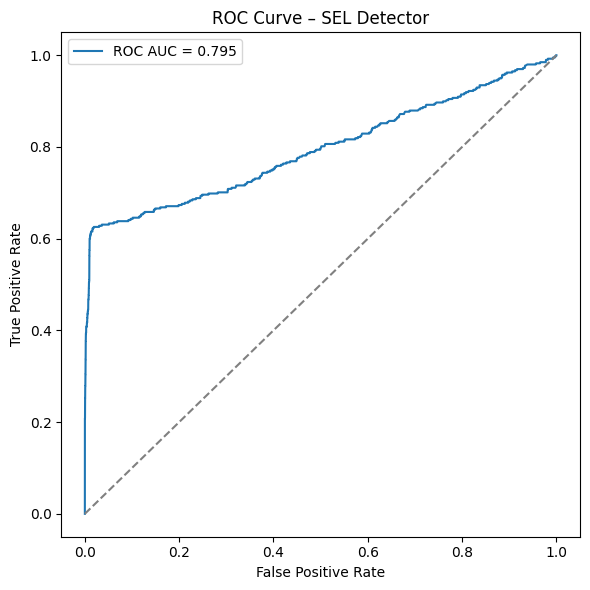

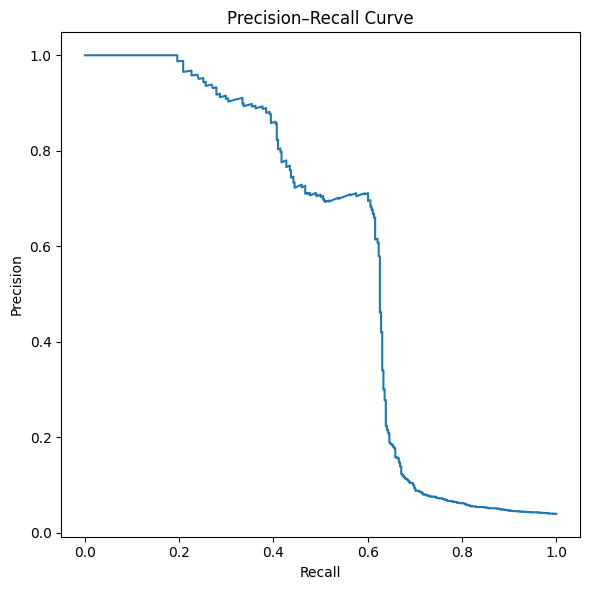

Best F1-threshold: 0.0975 | F1=0.651
Confusion Matrix:
 [[9503   97]
 [ 162  236]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      9600
           1       0.71      0.59      0.65       398

    accuracy                           0.97      9998
   macro avg       0.85      0.79      0.82      9998
weighted avg       0.97      0.97      0.97      9998

Average detection latency: 157.80 ms (max 449.00 ms)


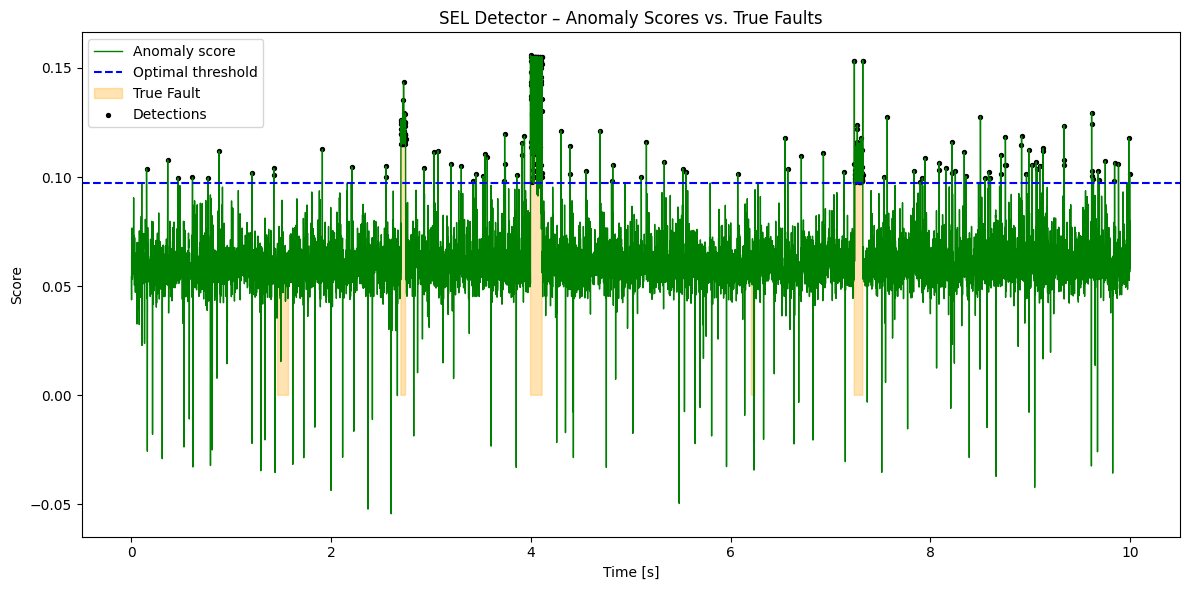

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)
import joblib

# -----------------------------
# Load model + data
# -----------------------------
df_feat = pd.read_csv("../data/cubesat_features.csv")

# Load the IsolationForest model (handles dict or plain model)
iso_loaded = joblib.load("../models/iforest_model.pkl")
if isinstance(iso_loaded, dict):
    iso = iso_loaded.get("model", None)
    if iso is None:
        raise KeyError("Model not found in iforest_model.pkl")
else:
    iso = iso_loaded

scaler = joblib.load("../models/feature_scaler.pkl")

X = df_feat[["dI_dt", "Vout_droop", "ripple_RMS", "efficiency", "dEff_dT"]].values
X_scaled = scaler.transform(X)

# -----------------------------
# Generate anomaly scores
# -----------------------------
scores = -iso.decision_function(X_scaled)
df_feat["anomaly_score"] = scores

# -----------------------------
# Evaluate various thresholds
# -----------------------------
y_true = df_feat["fault_label"].values

# 1) ROC curve
fpr, tpr, thr = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – SEL Detector")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Precision–Recall curve
prec, rec, thr_pr = precision_recall_curve(y_true, scores)
plt.figure(figsize=(6, 6))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.show()

# -----------------------------
# Pick optimal threshold (F1 max)
# -----------------------------
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1_scores)
threshold_opt = thr_pr[best_idx]
print(f"Best F1-threshold: {threshold_opt:.4f} | F1={f1_scores[best_idx]:.3f}")

df_feat["predicted_fault"] = (df_feat["anomaly_score"] > threshold_opt).astype(int)

# -----------------------------
# Confusion matrix & metrics
# -----------------------------
cm = confusion_matrix(y_true, df_feat["predicted_fault"])
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, df_feat["predicted_fault"]))

# -----------------------------
# Detection latency estimation
# -----------------------------
fs = 10_000
window_ms = 2
time_step = window_ms / 2 / 1000  # 50% overlap = 1 ms steps

det_latencies = []
fault_starts = np.where(np.diff(y_true) == 1)[0]
for s in fault_starts:
    # find first detection after start
    after = np.where(df_feat.index > s)[0]
    idx_detect = None
    for i in after:
        if df_feat.loc[i, "predicted_fault"] == 1:
            idx_detect = i
            break
    if idx_detect:
        latency = (idx_detect - s) * time_step * 1000  # ms
        det_latencies.append(latency)

if det_latencies:
    print(
        f"Average detection latency: {np.mean(det_latencies):.2f} ms "
        f"(max {np.max(det_latencies):.2f} ms)"
    )

# -----------------------------
# Visual validation
# -----------------------------
# If no time_s column, use sample index as fallback
if "time_s" in df_feat.columns:
    time_axis = df_feat["time_s"]
else:
    time_axis = np.arange(len(df_feat)) * time_step

plt.figure(figsize=(12, 6))
plt.plot(time_axis, df_feat["anomaly_score"],
         label="Anomaly score", lw=1, color="green")  # green curve
plt.axhline(threshold_opt, color="blue", linestyle="--", label="Optimal threshold")  # blue line
plt.fill_between(time_axis, 0, df_feat["anomaly_score"],
                 where=df_feat["fault_label"] == 1,
                 color="orange", alpha=0.3, label="True Fault")
plt.scatter(df_feat.loc[df_feat["predicted_fault"] == 1, time_axis.name],
            df_feat.loc[df_feat["predicted_fault"] == 1, "anomaly_score"],
            color="black", s=8, label="Detections")
plt.title("SEL Detector – Anomaly Scores vs. True Faults")
plt.xlabel("Time [s]")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
import time
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load model and data
iso = joblib.load("../models/iforest_model.pkl")
scaler = joblib.load("../models/feature_scaler.pkl")
df_feat = pd.read_csv("../data/cubesat_features.csv")

X = df_feat[["dI_dt","Vout_droop","ripple_RMS","efficiency","dEff_dT"]].values
X_scaled = scaler.transform(X)

# Measure prediction (inference) time
start = time.perf_counter()

# Perform the scoring
scores = -iso.decision_function(X_scaled)

end = time.perf_counter()

# Calculate execution time
elapsed_s = end - start
elapsed_ms = elapsed_s * 1000
time_per_sample = elapsed_ms / len(X_scaled)

print(f"✅ Total inference time: {elapsed_ms:.2f} ms for {len(X_scaled)} samples")
print(f"⏱️ Average per-sample: {time_per_sample:.5f} ms ({1/time_per_sample:.1f} samples/sec)")


✅ Total inference time: 42.87 ms for 9998 samples
⏱️ Average per-sample: 0.00429 ms (233.2 samples/sec)


In [5]:
runs = 50
t0 = time.perf_counter()
for _ in range(runs):
    _ = -iso.decision_function(X_scaled[:500])  # 500-sample batch
print(f"Average runtime per batch: {(time.perf_counter()-t0)/runs*1000:.3f} ms")


Average runtime per batch: 4.127 ms
